<a href="https://colab.research.google.com/github/grkidwell/max_charge_current/blob/master/max_charge_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maximum Charge Current

###Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt

###Parameters

In [0]:
Rbattery   = 0.2    # Rpcb + Rcable + Rbattery
Padaptor   = 90     # Full adaptor power.   Will be derated by aclim tolerance and charger efficiency
Vbatmin    = 11.1   # mimimum battery voltage where full power can be extracted from the adaptor.  This will be set by the EC

Aclim_tol  = .05
Efficiency = .95

###Functions

In [0]:
'''
Derive equation for Vchargemin and Ichargemax at max adaptor power

Voutmin-Ichargemax*Rbattery = Vbatmin
Voutmin = Padaptor/Ichargemax

Padaptor/Ichargemax = Vbatmin + Ichargemax*Rbattery
Padaptor = Vbatmin*Ichargemax + Rbattery*Ichargemax^2

Rbattery*Ichargemax^2 + Vbatmin*Ichargemax - Padaptor = 0

'''

def sqrt(x):
  return x**0.5

def quadsolver(a,b,c):
  x1 = (-b+sqrt(b**2-4*a*(-c)))/2/a
  x2 = (-b-sqrt(b**2-4*a*(-c)))/2/a
  return max(x1,x2)


###Results

In [25]:
#@title
Padap_actual = Padaptor*Efficiency*(1-Aclim_tol)
Imax = quadsolver(Rbattery,Vbatmin,Padap_actual)
voutmin=Padap_actual/Imax

print("For 90W Aadaptor, 3S Battery")
print("")
print("Max charge current = %3.1fA" % (Imax))
print("Charger output voltage = %3.1fV" % (voutmin))
print("Conduction loss = %3.1fW" % (Rbattery*Imax**2))


For 90W Aadaptor, 3S Battery

Max charge current = 6.5A
Charger output voltage = 12.4V
Conduction loss = 8.6W


### Graphs

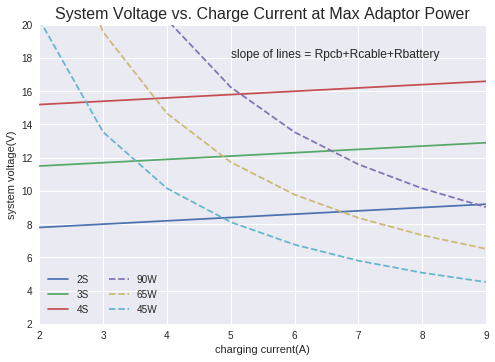

In [28]:
#@title
i=np.arange(2,10,1)
vsys_2S=Vbatmin*2/3+i*Rbattery
vsys_3S=Vbatmin+i*Rbattery
vsys_4S=Vbatmin*4/3+i*Rbattery
vsys_90=Padaptor/i*Efficiency*(1-Aclim_tol)
vsys_65=65/i*Efficiency*(1-Aclim_tol)
vsys_45=45/i*Efficiency*(1-Aclim_tol)

plt.plot(i, vsys_2S, label="2S")
plt.plot(i, vsys_3S, label="3S")
plt.plot(i, vsys_4S, label="4S")
plt.plot(i, vsys_90, label="90W", linestyle='dashed')
plt.plot(i, vsys_65, label="65W", linestyle='dashed')
plt.plot(i, vsys_45, label="45W", linestyle='dashed')
plt.plot()

plt.xlim(left=2, right=9)
plt.ylim(bottom=2,top=20)

plt.text(5,18,'slope of lines = Rpcb+Rcable+Rbattery')

plt.xlabel("charging current(A)")
plt.ylabel("system voltage(V)")
plt.title("System Voltage vs. Charge Current at Max Adaptor Power", fontsize=16)
plt.legend(ncol=2, loc='lower left')
plt.show()